Loading source corpus from: ../data/train.en
Loading target corpus from: ../data/train.es
Successfully loaded 5 parallel sentences.

Sample Parallel Sentences:
  EN: hello world
  ES: hola mundo
  EN: this is a test
  ES: esto es una prueba
  EN: i love natural language processing
  ES: me encanta el procesamiento del lenguaje natural
Loading embedding model: xlm-roberta-base

--- Testing Bidirectional Translation ---
Loading translation model: Helsinki-NLP/opus-mt-en-es
Loading translation model: Helsinki-NLP/opus-mt-es-en

English to Spanish Translation Samples:
  EN: hello world
  → ES: Hola mundo
  EN: this is a test
  → ES: Esto es una prueba.
  EN: i love natural language processing
  → ES: Me encanta el procesamiento del lenguaje natural

Spanish to English Translation Samples:
  ES: hola mundo
  → EN: Hello, world.
  ES: esto es una prueba
  → EN: This is a test.
  ES: me encanta el procesamiento del lenguaje natural
  → EN: I love the processing of natural language

--- Extrac

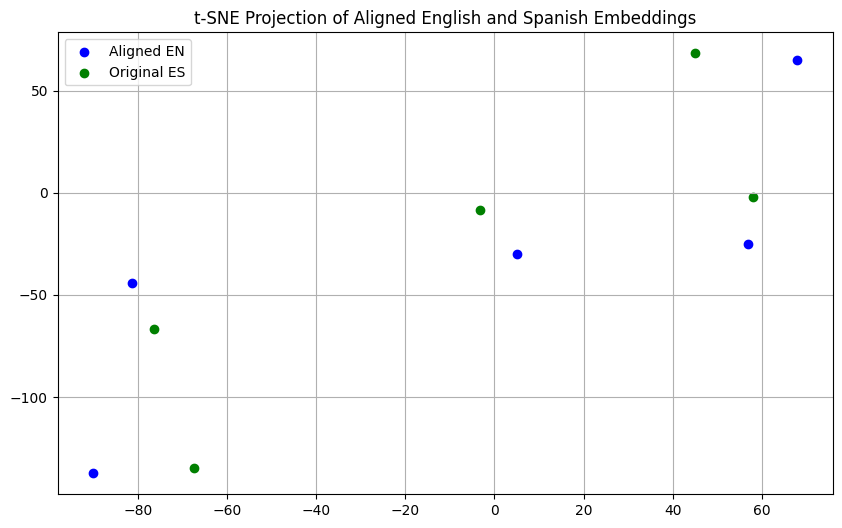


--- Summary Output ---
Average Cosine Similarity BEFORE Alignment: 0.9973
Average Cosine Similarity AFTER Alignment: 0.9998
BLEU (EN → ES): 0.00
BLEU (ES → EN): 15.97
Similarity (Aligned EN vs ES): 0.9969


In [9]:
# main_pipeline.ipynb (Python version for script execution)
import re
import sys
import os
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Add src to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data_loader import load_parallel_corpus
from src.model_handler import ModelHandler
from src.embedding_aligner import EmbeddingAligner
from src.evaluation import evaluate_translation_bleu, evaluate_alignment_similarity

# Configuration
SRC_LANG_CODE = 'en'
TGT_LANG_CODE = 'es'
SRC_CORPUS_FILE = f'../data/train.{SRC_LANG_CODE}'
TGT_CORPUS_FILE = f'../data/train.{TGT_LANG_CODE}'

TRANSLATION_MODEL_EN_ES = 'Helsinki-NLP/opus-mt-en-es'
TRANSLATION_MODEL_ES_EN = 'Helsinki-NLP/opus-mt-es-en'
EMBEDDING_MODEL = 'xlm-roberta-base'

# Load Data
src_sentences, tgt_sentences = load_parallel_corpus(SRC_CORPUS_FILE, TGT_CORPUS_FILE)
print("\nSample Parallel Sentences:")
for i in range(3):
    print(f"  EN: {src_sentences[i]}")
    print(f"  ES: {tgt_sentences[i]}")

# Initialize Handler
model_handler = ModelHandler(embedding_model_name=EMBEDDING_MODEL)

# Translation
print("\n--- Testing Bidirectional Translation ---")
translated_to_es = model_handler.translate(src_sentences, model_name=TRANSLATION_MODEL_EN_ES)
translated_to_en = model_handler.translate(tgt_sentences, model_name=TRANSLATION_MODEL_ES_EN)

print("\nEnglish to Spanish Translation Samples:")
for original, translated in zip(src_sentences[:3], translated_to_es[:3]):
    print(f"  EN: {original}\n  → ES: {translated}")

print("\nSpanish to English Translation Samples:")
for original, translated in zip(tgt_sentences[:3], translated_to_en[:3]):
    print(f"  ES: {original}\n  → EN: {translated}")

# Embedding Extraction
print("\n--- Extracting Cross-Lingual Embeddings ---")
src_embeddings = model_handler.get_embeddings(src_sentences)
tgt_embeddings = model_handler.get_embeddings(tgt_sentences)
print(f"Shape of EN embeddings: {src_embeddings.shape}")
print(f"Shape of ES embeddings: {tgt_embeddings.shape}")

# Evaluate Pre-Alignment Similarity
initial_similarity = evaluate_alignment_similarity(src_embeddings, tgt_embeddings)
print(f"\nAverage Cosine Similarity BEFORE Alignment: {initial_similarity:.4f}")

# Embedding Alignment
print("\n--- Aligning Embedding Spaces ---")
aligner = EmbeddingAligner()
aligner.learn_mapping(src_embeddings, tgt_embeddings)
aligned_src_embeddings = aligner.align_embeddings(src_embeddings)
print(f"Shape of aligned EN embeddings: {aligned_src_embeddings.shape}")

# Evaluate Post-Alignment Similarity
final_similarity = evaluate_alignment_similarity(aligned_src_embeddings, tgt_embeddings)
print(f"\nAverage Cosine Similarity AFTER Alignment: {final_similarity:.4f}")

# Evaluate Translation Quality
print("\n--- Evaluating Translation Quality ---")


def normalize(text):
    text = text.lower()
    text = re.sub(r"[!.,¿?¡]", "", text)
    return text.strip()

normalized_refs = [[normalize(t)] for t in tgt_sentences]
normalized_hyps = [normalize(t) for t in translated_to_es]

bleu_en_es = evaluate_translation_bleu(normalized_hyps, normalized_refs)


print(f"BLEU (EN → ES): {bleu_en_es:.2f}")

en_references = [[ref] for ref in src_sentences]
bleu_es_en = evaluate_translation_bleu(translated_to_en, en_references)
print(f"BLEU (ES → EN): {bleu_es_en:.2f}")

# Inference Example
print("\n--- Final Inference Example ---")
new_sentence_en = "this is a new sentence for alignment"
print(f"Input EN: {new_sentence_en}")
new_sentence_es = model_handler.translate([new_sentence_en], model_name=TRANSLATION_MODEL_EN_ES)[0]
print(f"Translated to ES: {new_sentence_es}")

new_embedding_en = model_handler.get_embeddings([new_sentence_en])
new_embedding_es = model_handler.get_embeddings([new_sentence_es])
aligned_new_embedding_en = aligner.align_embeddings(new_embedding_en)

example_similarity = evaluate_alignment_similarity(aligned_new_embedding_en, new_embedding_es)
print(f"Similarity (Aligned EN vs ES): {example_similarity:.4f}")

# Visualize with t-SNE
print("\n--- Visualizing Embedding Spaces with t-SNE ---")
n_samples = src_embeddings.shape[0] + tgt_embeddings.shape[0]
perplexity = max(2, min(30, n_samples // 3))

combined_embeddings = np.vstack((aligned_src_embeddings, tgt_embeddings))
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
emb_2d = tsne.fit_transform(combined_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(emb_2d[:len(src_sentences), 0], emb_2d[:len(src_sentences), 1], c='blue', label='Aligned EN')
plt.scatter(emb_2d[len(src_sentences):, 0], emb_2d[len(src_sentences):, 1], c='green', label='Original ES')
plt.title("t-SNE Projection of Aligned English and Spanish Embeddings")
plt.legend()
plt.grid(True)
plt.show()

# Log Final Summary
print("\n--- Summary Output ---")
print(f"Average Cosine Similarity BEFORE Alignment: {initial_similarity:.4f}")
print(f"Average Cosine Similarity AFTER Alignment: {final_similarity:.4f}")
print(f"BLEU (EN → ES): {bleu_en_es:.2f}")
print(f"BLEU (ES → EN): {bleu_es_en:.2f}")
print(f"Similarity (Aligned EN vs ES): {example_similarity:.4f}")


In [10]:
print("\n--- EN → ES Translation Debug ---")
for ref, hyp in zip(tgt_sentences, translated_to_es):
    print(f"REF: {ref}")
    print(f"HYP: {hyp}")



--- EN → ES Translation Debug ---
REF: hola mundo
HYP: Hola mundo
REF: esto es una prueba
HYP: Esto es una prueba.
REF: me encanta el procesamiento del lenguaje natural
HYP: Me encanta el procesamiento del lenguaje natural
REF: el gato está durmiendo en la alfombra
HYP: el gato está durmiendo en el tapete
REF: la traducción automática es fascinante
HYP: traducción automática es fascinante


In [11]:
bleu_en_es = evaluate_translation_bleu(normalized_hyps, normalized_refs)


In [12]:
bleu_en_es

0.0